# Synthetic data test: Try different structural indices

In [1]:
import numpy as np
import harmonica as hm
import verde as vd
import matplotlib.pyplot as plt
import xrft
import euler

In [20]:
region = [0, 35e3, 0, 25e3]
coordinates = vd.grid_coordinates(region, spacing=500, extra_coords=800)
inclination, declination = 35, -5
base_level = 100
main_field = hm.magnetic_angles_to_vec(1, inclination, declination)

## Prism

/home/leo/miniforge3/envs/euler-inversion/lib/python3.12/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


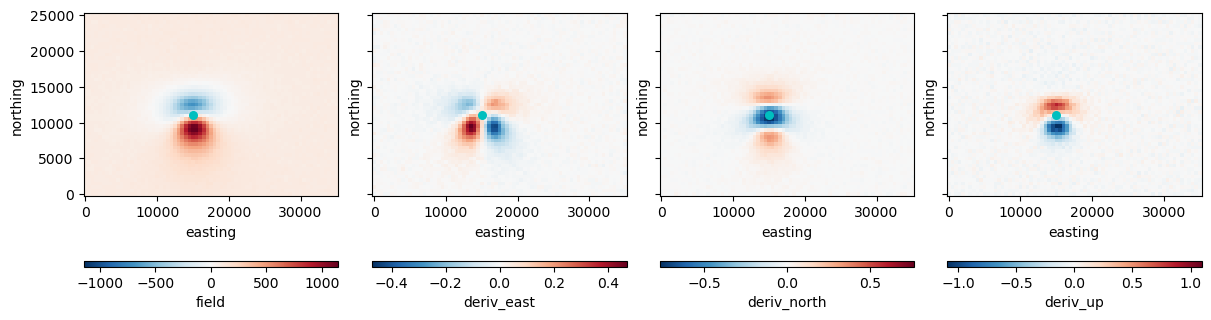

In [33]:
true_coordinates = (15e3, 11e3, -2e3)
size = 1.5e3
magnetic_field = hm.prism_magnetic(
    coordinates, 
    prisms=[
        true_coordinates[0] - size, 
        true_coordinates[0] + size, 
        true_coordinates[1] - size, 
        true_coordinates[1] + size, 
        true_coordinates[2] - size, 
        true_coordinates[2] + size, 
    ],
    magnetization=hm.magnetic_angles_to_vec(10, inclination, declination),
    field="b",
)
magnetic_anomaly = sum(b * f for b, f in zip(magnetic_field, main_field)) + base_level
magnetic_anomaly += np.random.default_rng(42).normal(0, 5, size=magnetic_anomaly.shape)

# Make a grid and calculate derivatives
# Can't have the height as a coordinate because of a problem with xrft
data = vd.make_xarray_grid(coordinates[:2], (magnetic_anomaly, coordinates[-1]), data_names=["field", "height"])
data["deriv_east"] = hm.derivative_easting(data.field)
data["deriv_north"] = hm.derivative_northing(data.field)
pad_width = {
    "easting": data.easting.size // 3,
    "northing": data.northing.size // 3,
}
padded = xrft.pad(data.field, pad_width, mode="linear_ramp", constant_values=None)
data["deriv_up"] = xrft.unpad(hm.derivative_upward(padded), pad_width)
# Add back the height
data = data.assign_coords(height=data.height)

fig, axes = plt.subplots(1, 4, figsize=(12, 5), layout='constrained', sharey=True)
for field, ax in zip(["field", "deriv_east", "deriv_north", "deriv_up"], axes.ravel()):
    data[field].plot.pcolormesh(ax=ax, cbar_kwargs=dict(orientation="horizontal", aspect=50))
    ax.set_aspect("equal")
    tmp = ax.scatter(*true_coordinates[:2], c="c", s=30)
plt.show()

In [34]:
prism = {}
for si in [1, 2, 3]:    
    prism[si] = euler.EulerInversion(structural_index=si).fit_grid(data.field, data.deriv_east, data.deriv_north, data.deriv_up)
    print(f"SI={si} | RMSE={prism[si].data_misfit_[-1]} | Position={prism[si].source_location_}")

SI=1 | RMSE=1.3620156659052105 | Position=[15546.37931908 11314.24371969  -383.53535461]
SI=2 | RMSE=0.6375790846688388 | Position=[15002.01021279 11057.50654748 -1301.42148591]
SI=3 | RMSE=0.42014934522100733 | Position=[14991.80292337 11002.63478207 -2333.62092255]


## Pipe

/home/leo/miniforge3/envs/euler-inversion/lib/python3.12/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


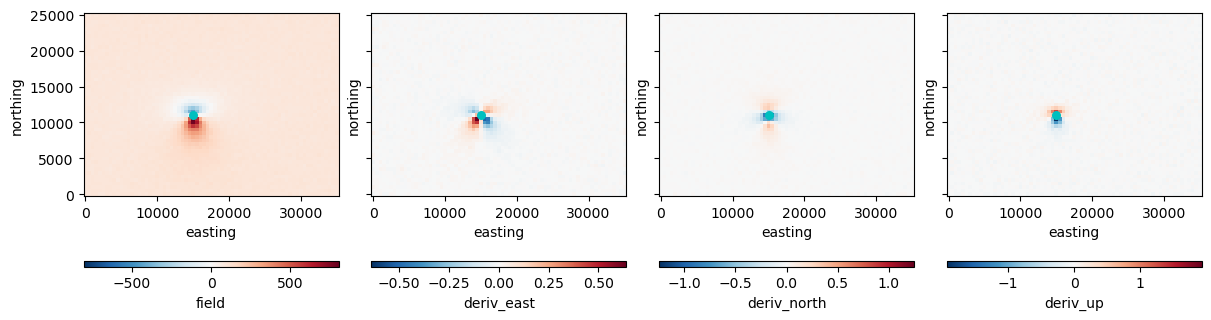

In [40]:
true_coordinates = (15e3, 11e3, 0e3)
size = 0.25e3
magnetic_field = hm.prism_magnetic(
    coordinates, 
    prisms=[
        true_coordinates[0] - size, 
        true_coordinates[0] + size, 
        true_coordinates[1] - size, 
        true_coordinates[1] + size, 
        true_coordinates[2] - 10e3, 
        true_coordinates[2], 
    ],
    magnetization=hm.magnetic_angles_to_vec(50, inclination, declination),
    field="b",
)
magnetic_anomaly = sum(b * f for b, f in zip(magnetic_field, main_field)) + base_level
magnetic_anomaly += np.random.default_rng(42).normal(0, 5, size=magnetic_anomaly.shape)

# Make a grid and calculate derivatives
# Can't have the height as a coordinate because of a problem with xrft
data = vd.make_xarray_grid(coordinates[:2], (magnetic_anomaly, coordinates[-1]), data_names=["field", "height"])
data["deriv_east"] = hm.derivative_easting(data.field)
data["deriv_north"] = hm.derivative_northing(data.field)
pad_width = {
    "easting": data.easting.size // 3,
    "northing": data.northing.size // 3,
}
padded = xrft.pad(data.field, pad_width, mode="linear_ramp", constant_values=None)
data["deriv_up"] = xrft.unpad(hm.derivative_upward(padded), pad_width)
# Add back the height
data = data.assign_coords(height=data.height)

fig, axes = plt.subplots(1, 4, figsize=(12, 5), layout='constrained', sharey=True)
for field, ax in zip(["field", "deriv_east", "deriv_north", "deriv_up"], axes.ravel()):
    data[field].plot.pcolormesh(ax=ax, cbar_kwargs=dict(orientation="horizontal", aspect=50))
    ax.set_aspect("equal")
    tmp = ax.scatter(*true_coordinates[:2], c="c", s=30)
plt.show()

In [41]:
pipe = {}
for si in [1, 2, 3]:    
    pipe[si] = euler.EulerInversion(structural_index=si).fit_grid(data.field, data.deriv_east, data.deriv_north, data.deriv_up)
    print(f"SI={si} | RMSE={pipe[si].data_misfit_[-1]} | Position={pipe[si].source_location_}")

SI=1 | RMSE=0.6127324806825779 | Position=[15007.24458635 11023.95980388   315.78800339]
SI=2 | RMSE=0.3812197511734177 | Position=[15003.53031019 10999.34993827  -150.50611546]
SI=3 | RMSE=0.41770644636811727 | Position=[15001.92749342 10994.07583493  -725.56530952]
